In [57]:
# for data manipulation
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# for data evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, plot_roc_curve, roc_auc_score, average_precision_score, \
                            precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay


In [2]:
# create a function to run the metrics and store it in dataframe
evaluation_list = []

def run_score(fit_model, model, scale=False):
    
    summary_dict = {}

    if scale:
        y_pred = fit_model.predict(X_test_sc)
        train = fit_model.score(X_train_sc, y_train)
        test = fit_model.score(X_test_sc, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test_sc)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")
    
    else:      
        y_pred = fit_model.predict(X_test)
        train = fit_model.score(X_train, y_train)
        test = fit_model.score(X_test, y_test)
        roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test)[:,1])

        # store the results in summary dictionary
        summary_dict['model'] = model
        summary_dict['train accuracy'] = train
        summary_dict['test accuracy'] = test
        summary_dict['precision'] = precision_score(y_test, y_pred)
        summary_dict['recall'] = recall_score(y_test, y_pred)
        summary_dict['average precision'] = average_precision_score(y_test, y_pred)
        summary_dict['f1_score'] = f1_score(y_test, y_pred)
        summary_dict['roc_auc'] = roc_auc

        evaluation_list.append(summary_dict)

        # print summarize results
        print(f"====== {model}'s Metrics ======")
        print(f"Train Score: {train}")
        print(f"Test Score: {test}")    
        print(f"Precision Score: {precision_score(y_test, y_pred)}")
        print(f"Recall Score: {recall_score(y_test, y_pred)}")
        print(f"Average Precision: {average_precision_score(y_test, y_pred)}")
        print(f"f1-Score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc Score: {roc_auc}")

        print()
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        print('== confusion matrix ==')
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

Precision measures how accurate your predictions are. i.e. the percentage of your predictions are correct.

Precision = TP / TP+FP

mAP (mean average precision) is the average of AP.

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

### Load Cleaned and Combined Data

In [3]:
# # load the cleaned and combined datasets
# train_cleaned = pd.read_csv('../datasets/train_cleaned.csv')

In [4]:
# load the pickle file
train_final = pd.read_pickle('../datasets/train_final.pkl')

In [5]:
print(train_final.shape)
train_final.head(3)

(1296675, 74)


,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,...,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,customer_segment,cluster
0,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,7.27,7.27,7.27,7.27,7.27,7.27,7.27,1,Medium_Value_Cust,43
1,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,52.94,52.94,52.94,79.01,79.39,79.39,79.39,0,Medium_Value_Cust,43
2,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,47.10,47.10,47.10,82.08,82.08,82.08,82.08,0,Medium_Value_Cust,43


In [6]:
train_final.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'is_male',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance', 'amt_group', 'age_group', 'pre_amt', 'cum_sum', 'amt_diff',
       'pct_change', 'amt_avg', 'diff_minutes_pre_trans', 'diff_distance',
       'trans_last_1h', 'trans_last_24h', 'trans_last_7d', 'trans_last_30d',
       'avg_last_1h', 'avg_last_24h', 'avg_last_7d', 'avg_last_30d',
       'min_last_1h', 'min_last_24h', 'min_last_7d', 'min_last_30d',
       'max_last_1h', 'max_last_24h', 'max_last_7d', 'max_last_30d',
       'merch_last_24h', 'merch_last_7d', 'merch_last_14d', 'merch_last_30d',
       'avg_merch_last_24h', 'avg_merch_last_7d', 'avg_merch_last_14d',
       'avg_merch_last_30d', 'min_mer

In [12]:
columns_to_drop = ['trans_datetime', 'cc_num', 'merchant', 'street', 'city', 'zip', 'lat', 'long', 'city_pop', 'job',
                   'trans_num', 'merch_lat', 'merch_long', 'name', 'coords_ori', 'coords_merch', 'trans_year', 'trans_minute']

columns_to_drop_2 = ['trans_datetime', 'cc_num','gender', 'street', 'job', 'zip',
                   'dob', 'trans_num', 'name', 'coords_ori', 'coords_merch']

columns_to_drop_3 = ['trans_datetime', 'cc_num', 'merchant', 'street', 'city', 'zip', 'job',
                       'dob', 'trans_num', 'name', 'coords_ori', 'coords_merch', 'dob_year']

In [31]:
# columns_to_use = ['category', 'amt', 'is_male', 'city', 'lat', 'long', 'is_fraud', 'city_pop','merch_lat','merch_long','trans_month',
#                   'trans_week', 'trans_day', 'trans_hour', 'trans_dayofweek', 'age', 'distance', 
#                   'pre_amt', 'cum_sum', 'amt_diff', 'pct_change', 'amt_avg', 'diff_pre_trans_datetime_minute', 
#                   'diff_distance','trans_last_1_hour', 'trans_last_24_hour', 'trans_last_7_day', 'trans_last_30_day', 
#                   'avg_last_1_hour', 'avg_last_24_hour', 'avg_last_7_day', 'avg_last_30_day']

In [13]:
train_final.drop(columns = columns_to_drop, axis=1, inplace=True)

In [14]:
# specified X and Y
X = train_final.drop('is_fraud', axis=1)
y = train_final['is_fraud']

In [11]:
# # specified X and Y
# X = train_final[columns_to_use].drop('is_fraud', axis=1)
# y = train_final['is_fraud']

In [20]:
X.head().iloc[:,5:]

,trans_week,trans_day,trans_hour,trans_dayofweek,age,distance,amt_group,age_group,pre_amt,cum_sum,...,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,customer_segment,cluster
0,1,1,12,1,33,127.629296,low,23_33,0.00,7.27,...,7.27,7.27,7.27,7.27,7.27,7.27,7.27,1,Medium_Value_Cust,43
1,1,2,8,2,33,110.202992,above_medium,23_33,7.27,60.21,...,52.94,52.94,52.94,79.01,79.39,79.39,79.39,0,Medium_Value_Cust,43
2,1,2,8,2,33,21.841827,above_medium,23_33,52.94,142.29,...,47.10,47.10,47.10,82.08,82.08,82.08,82.08,0,Medium_Value_Cust,43
3,1,2,12,2,33,87.124420,medium,23_33,82.08,177.08,...,26.85,26.85,26.85,99.84,99.84,99.84,99.84,0,Medium_Value_Cust,43
4,1,2,13,2,33,74.352876,medium,23_33,34.79,204.26,...,24.46,24.46,24.46,173.49,173.49,173.49,173.49,0,Medium_Value_Cust,43


In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 55 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   category                1296675 non-null  object  
 1   amt                     1296675 non-null  float64 
 2   is_male                 1296675 non-null  int64   
 3   state                   1296675 non-null  object  
 4   trans_month             1296675 non-null  int64   
 5   trans_week              1296675 non-null  int32   
 6   trans_day               1296675 non-null  int64   
 7   trans_hour              1296675 non-null  int64   
 8   trans_dayofweek         1296675 non-null  int64   
 9   age                     1296675 non-null  int64   
 10  distance                1296675 non-null  float64 
 11  amt_group               1296675 non-null  category
 12  age_group               1296675 non-null  category
 13  pre_amt                 1296675 non-null  

In [23]:
# convert datetime to object type for dummified
for col in ['trans_month','trans_week','trans_day','trans_hour','trans_dayofweek','cluster']:
    X[col] = X[col].astype('object')

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 55 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   category                1296675 non-null  object  
 1   amt                     1296675 non-null  float64 
 2   is_male                 1296675 non-null  int64   
 3   state                   1296675 non-null  object  
 4   trans_month             1296675 non-null  object  
 5   trans_week              1296675 non-null  object  
 6   trans_day               1296675 non-null  object  
 7   trans_hour              1296675 non-null  object  
 8   trans_dayofweek         1296675 non-null  object  
 9   age                     1296675 non-null  int64   
 10  distance                1296675 non-null  float64 
 11  amt_group               1296675 non-null  category
 12  age_group               1296675 non-null  category
 13  pre_amt                 1296675 non-null  

In [25]:
X.select_dtypes(include=['object','category']).columns

Index(['category', 'state', 'trans_month', 'trans_week', 'trans_day',
       'trans_hour', 'trans_dayofweek', 'amt_group', 'age_group',
       'customer_segment', 'cluster'],
      dtype='object')

In [26]:
# one-hot encoding 5 category features: `category`, `state`
X_encoded = pd.get_dummies(X, columns = X.select_dtypes(include=['object','category']).columns, 
                           drop_first=True)

In [27]:
print(X_encoded.shape)
X_encoded.head(2)

(1296675, 288)


,amt,is_male,age,distance,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,...,cluster_34,cluster_35,cluster_36,cluster_37,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43
0,7.27,0,33,127.629296,0.00,7.27,0.00,0.000000,7.270,0.0,...,0,0,0,0,0,0,0,0,0,1
1,52.94,0,33,110.202992,7.27,60.21,45.67,6.281981,30.105,1197.7,...,0,0,0,0,0,0,0,0,0,1


In [17]:
# gss = GroupShuffleSplit(n_splits = 2, random_state=42, test_size=0.25)
# split = gss.split(train_final, groups= train_final['cc_num'])
# train_inds, test_inds = next(split)

# train = train_final.iloc[train_inds]
# test = train_final.iloc[test_inds]

In [18]:
# train.sort_values(['cc_num','trans_datetime'])['is_fraud'].value_counts(normalize=True)

In [19]:
# test.sort_values(['cc_num','trans_datetime'])['is_fraud'].value_counts(normalize=True)

In [20]:
# X_train = train.drop(columns=columns_to_drop)
# X_test = test.drop(columns=columns_to_drop)

# y_train = train['is_fraud']
# y_test = test['is_fraud']

In [21]:
# # check shape of the train and test sets
# print(f'X_train shape: {X_train.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'y_train shape: {y_train.shape}')
# print(f'y_test shape: {y_test.shape}')

In [22]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [23]:
# X = train_final.drop(columns=columns_to_drop)
# y = train_final['is_fraud']

In [24]:
# Robust Scaler


### Train-Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, 
                                                    random_state = 42,
                                                    #shuffle = False)
                                                    stratify = y)

In [30]:
# check shape of the train and test sets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (972506, 288)
X_test shape: (324169, 288)
y_train shape: (972506,)
y_test shape: (324169,)


In [32]:
sum(y_train) / len(y_train) , sum(y_test) / len(y_test)

(0.005788139096314059, 0.00579018968500998)

### Logistic Regression

In [33]:
# Logistic Regression required to scale the datasets
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [75]:
%%time

# Instantiate our model.
lr = LogisticRegression(max_iter = 1000, random_state = 42)

# Fit our model.
lr.fit(X_train_sc, y_train)

Wall time: 2min 38s


LogisticRegression(max_iter=1000, random_state=42)

In [76]:
# print the summarize report and store the values
run_score(lr, 'Logistic Regression', scale=True)

====== Logistic Regression's Metrics ======
Train Score: 0.9972668549088644
Test Score: 0.9970879386986418
Precision Score: 0.8884263114071607
Recall Score: 0.5684603090037293
Average Precision: 0.5075337921770371
f1-Score: 0.6933073424301495
roc_auc Score: 0.9798792804767077

== confusion matrix ==
True Negatives: 322158
False Positives: 134
False Negatives: 810
True Positives: 1067


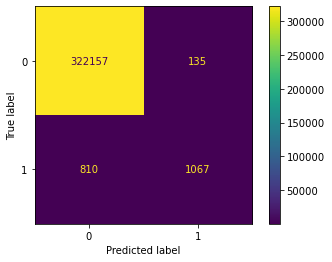

In [36]:
# plot confusion matrix
lr_predictions = lr.predict(X_test_sc)

lr_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, lr_predictions, labels=lr.classes_), 
                                 display_labels=lr.classes_)
lr_disp.plot();

C:\Users\chua_\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


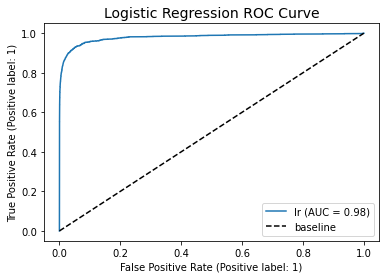

In [37]:
# plot roc curve
plot_roc_curve(lr, X_test_sc, y_test, name = 'lr')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Logistic Regression ROC Curve', fontsize=14)
plt.legend();

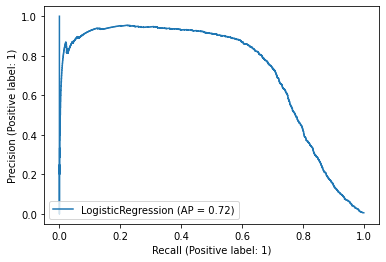

In [38]:
PrecisionRecallDisplay.from_estimator(lr, X_test_sc, y_test);

__PRECISION-RECALL CURVES__

It is used for evaluating the performance of binary classificaiton where there is super imbalanced classes.

In [39]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997262,0.997085,0.887687,0.56846,0.507114,0.693082,0.979846


### Gaussian Naive Bayes

In [40]:
%%time

gnb = GaussianNB()

# Fit our model.
gnb.fit(X_train, y_train)

Wall time: 8.86 s


GaussianNB()

In [41]:
# print the summarize report and store the values
run_score(gnb, 'Gaussian Naive Bayes')

====== Gaussian Naive Bayes's Metrics ======
Train Score: 0.9789512866758663
Test Score: 0.9786500251412072
Precision Score: 0.17913486005089058
Recall Score: 0.7501331912626532
Average Precision: 0.13582178045494064
f1-Score: 0.28920612098182186
roc_auc Score: 0.9480102677068833

== confusion matrix ==
True Negatives: 315840
False Positives: 6452
False Negatives: 469
True Positives: 1408


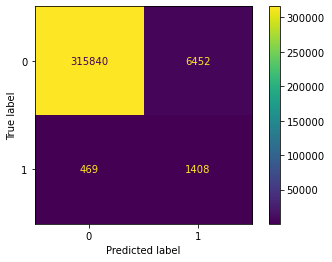

In [44]:
# plot confusion matrix
gnb_predictions = gnb.predict(X_test)

gnb_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, gnb_predictions, labels=gnb.classes_), 
                                 display_labels=gnb.classes_)
gnb_disp.plot();

C:\Users\chua_\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


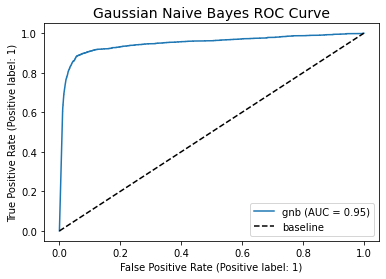

In [45]:
# plot roc curve
plot_roc_curve(gnb, X_test, y_test, name = 'gnb')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Gaussian Naive Bayes ROC Curve', fontsize=14)
plt.legend();

In [46]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997262,0.997085,0.887687,0.568460,0.507114,0.693082,0.979846
1,Gaussian Naive Bayes,0.978951,0.978650,0.179135,0.750133,0.135822,0.289206,0.948010


### Random Forest Classifier

In [47]:
%%time

rf = RandomForestClassifier(random_state = 42)

# Fit our model.
rf.fit(X_train, y_train)

Wall time: 5min 16s


RandomForestClassifier(random_state=42)

In [48]:
# print the summarize report and store the values
run_score(rf, 'Random Forest Classifier')

====== Random Forest Classifier's Metrics ======
Train Score: 1.0
Test Score: 0.9987352276127576
Precision Score: 0.980983606557377
Recall Score: 0.797016515716569
Average Precision: 0.7830354489503595
f1-Score: 0.879482657260435
roc_auc Score: 0.993895615633843

== confusion matrix ==
True Negatives: 322263
False Positives: 29
False Negatives: 381
True Positives: 1496


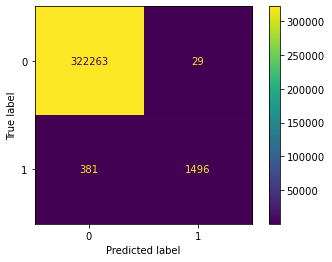

In [49]:
# plot confusion matrix
rf_predictions = rf.predict(X_test)

rf_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, rf_predictions, labels=rf.classes_), 
                                 display_labels=rf.classes_)
rf_disp.plot();

C:\Users\chua_\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


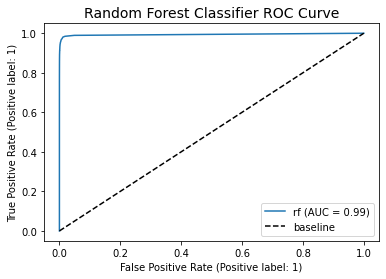

In [50]:
# plot roc curve
plot_roc_curve(rf, X_test, y_test, name = 'rf')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest Classifier ROC Curve', fontsize=14)
plt.legend();

In [51]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997262,0.997085,0.887687,0.568460,0.507114,0.693082,0.979846
1,Gaussian Naive Bayes,0.978951,0.978650,0.179135,0.750133,0.135822,0.289206,0.948010
2,Random Forest Classifier,1.000000,0.998735,0.980984,0.797017,0.783035,0.879483,0.993896


### XGBoost

In [52]:
%%time

# Instantiate the model
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, seed=42)

# Fit the model
xgb.fit(X_train, y_train)

[17:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2min 4s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [53]:
# print the summarize report and store the values
run_score(xgb, 'XGBClassifier')

====== XGBClassifier's Metrics ======
Train Score: 0.9999742932177282
Test Score: 0.9993861226705824
Precision Score: 0.9844110854503464
Recall Score: 0.9083644112946191
Average Precision: 0.8947345835475026
f1-Score: 0.9448600720421169
roc_auc Score: 0.9997003928065286

== confusion matrix ==
True Negatives: 322265
False Positives: 27
False Negatives: 172
True Positives: 1705


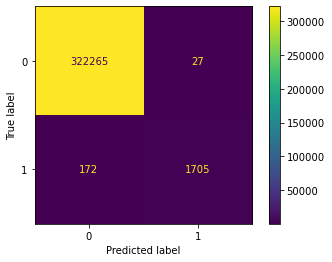

In [54]:
# plot confusion matrix
xgb_predictions = xgb.predict(X_test)

xgb_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, xgb_predictions, labels=xgb.classes_), 
                                 display_labels=xgb.classes_)
xgb_disp.plot();

C:\Users\chua_\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


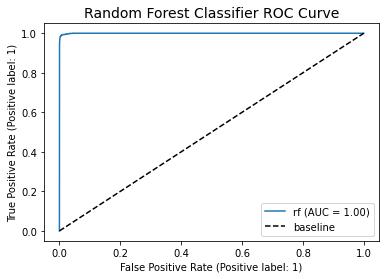

In [55]:
# plot roc curve
plot_roc_curve(xgb, X_test, y_test, name = 'rf')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest Classifier ROC Curve', fontsize=14)
plt.legend();

In [56]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997262,0.997085,0.887687,0.568460,0.507114,0.693082,0.979846
1,Gaussian Naive Bayes,0.978951,0.978650,0.179135,0.750133,0.135822,0.289206,0.948010
2,Random Forest Classifier,1.000000,0.998735,0.980984,0.797017,0.783035,0.879483,0.993896
3,XGBClassifier,0.999974,0.999386,0.984411,0.908364,0.894735,0.944860,0.999700


In [254]:
# !pip install catboost

In [40]:
y_train.sum()/y_train.shape[0]

0.005788139096314059

In [ ]:
# # Import Bagging Classifier.
# from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, \
#                             GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC

### CatBoost

In [73]:
%%time
cat = CatBoostClassifier(random_seed=42)
cat.fit(X_train, y_train)

Learning rate set to 0.19443
0:	learn: 0.2164024	total: 90.3ms	remaining: 1m 30s
1:	learn: 0.0802667	total: 165ms	remaining: 1m 22s
2:	learn: 0.0358552	total: 231ms	remaining: 1m 16s
3:	learn: 0.0210720	total: 297ms	remaining: 1m 13s
4:	learn: 0.0152497	total: 362ms	remaining: 1m 11s
5:	learn: 0.0121346	total: 434ms	remaining: 1m 11s
6:	learn: 0.0098905	total: 506ms	remaining: 1m 11s
7:	learn: 0.0083568	total: 574ms	remaining: 1m 11s
8:	learn: 0.0074177	total: 649ms	remaining: 1m 11s
9:	learn: 0.0069433	total: 718ms	remaining: 1m 11s
10:	learn: 0.0065363	total: 799ms	remaining: 1m 11s
11:	learn: 0.0059879	total: 878ms	remaining: 1m 12s
12:	learn: 0.0057586	total: 957ms	remaining: 1m 12s
13:	learn: 0.0056093	total: 1.02s	remaining: 1m 12s
14:	learn: 0.0053190	total: 1.09s	remaining: 1m 11s
15:	learn: 0.0052001	total: 1.16s	remaining: 1m 11s
16:	learn: 0.0049212	total: 1.23s	remaining: 1m 11s
17:	learn: 0.0048082	total: 1.29s	remaining: 1m 10s
18:	learn: 0.0047000	total: 1.37s	remaining:

160:	learn: 0.0016279	total: 11.2s	remaining: 58.4s
161:	learn: 0.0016241	total: 11.3s	remaining: 58.3s
162:	learn: 0.0016209	total: 11.3s	remaining: 58.2s
163:	learn: 0.0015939	total: 11.4s	remaining: 58.2s
164:	learn: 0.0015853	total: 11.5s	remaining: 58.1s
165:	learn: 0.0015815	total: 11.6s	remaining: 58.1s
166:	learn: 0.0015781	total: 11.6s	remaining: 58s
167:	learn: 0.0015681	total: 11.7s	remaining: 57.9s
168:	learn: 0.0015657	total: 11.8s	remaining: 57.8s
169:	learn: 0.0015622	total: 11.8s	remaining: 57.7s
170:	learn: 0.0015579	total: 11.9s	remaining: 57.6s
171:	learn: 0.0015541	total: 12s	remaining: 57.5s
172:	learn: 0.0015517	total: 12s	remaining: 57.5s
173:	learn: 0.0015337	total: 12.1s	remaining: 57.4s
174:	learn: 0.0015273	total: 12.2s	remaining: 57.4s
175:	learn: 0.0015233	total: 12.2s	remaining: 57.3s
176:	learn: 0.0015222	total: 12.3s	remaining: 57.3s
177:	learn: 0.0015133	total: 12.4s	remaining: 57.2s
178:	learn: 0.0015069	total: 12.4s	remaining: 57.1s
179:	learn: 0.0015

321:	learn: 0.0009602	total: 22.3s	remaining: 46.9s
322:	learn: 0.0009516	total: 22.3s	remaining: 46.8s
323:	learn: 0.0009503	total: 22.4s	remaining: 46.7s
324:	learn: 0.0009490	total: 22.5s	remaining: 46.7s
325:	learn: 0.0009465	total: 22.5s	remaining: 46.6s
326:	learn: 0.0009440	total: 22.6s	remaining: 46.5s
327:	learn: 0.0009410	total: 22.7s	remaining: 46.4s
328:	learn: 0.0009363	total: 22.7s	remaining: 46.4s
329:	learn: 0.0009336	total: 22.8s	remaining: 46.3s
330:	learn: 0.0009302	total: 22.9s	remaining: 46.2s
331:	learn: 0.0009294	total: 22.9s	remaining: 46.1s
332:	learn: 0.0009285	total: 23s	remaining: 46.1s
333:	learn: 0.0009237	total: 23.1s	remaining: 46s
334:	learn: 0.0009230	total: 23.1s	remaining: 45.9s
335:	learn: 0.0009226	total: 23.2s	remaining: 45.8s
336:	learn: 0.0009209	total: 23.3s	remaining: 45.8s
337:	learn: 0.0009182	total: 23.3s	remaining: 45.7s
338:	learn: 0.0009173	total: 23.4s	remaining: 45.6s
339:	learn: 0.0009154	total: 23.5s	remaining: 45.6s
340:	learn: 0.00

480:	learn: 0.0006205	total: 33.3s	remaining: 35.9s
481:	learn: 0.0006194	total: 33.4s	remaining: 35.9s
482:	learn: 0.0006174	total: 33.4s	remaining: 35.8s
483:	learn: 0.0006169	total: 33.5s	remaining: 35.7s
484:	learn: 0.0006160	total: 33.6s	remaining: 35.7s
485:	learn: 0.0006155	total: 33.7s	remaining: 35.6s
486:	learn: 0.0006150	total: 33.7s	remaining: 35.5s
487:	learn: 0.0006140	total: 33.8s	remaining: 35.5s
488:	learn: 0.0006103	total: 33.9s	remaining: 35.4s
489:	learn: 0.0006093	total: 33.9s	remaining: 35.3s
490:	learn: 0.0006086	total: 34s	remaining: 35.2s
491:	learn: 0.0006075	total: 34.1s	remaining: 35.2s
492:	learn: 0.0006070	total: 34.1s	remaining: 35.1s
493:	learn: 0.0006060	total: 34.2s	remaining: 35s
494:	learn: 0.0006047	total: 34.2s	remaining: 34.9s
495:	learn: 0.0006042	total: 34.3s	remaining: 34.9s
496:	learn: 0.0006039	total: 34.4s	remaining: 34.8s
497:	learn: 0.0006033	total: 34.5s	remaining: 34.7s
498:	learn: 0.0006020	total: 34.5s	remaining: 34.7s
499:	learn: 0.00

640:	learn: 0.0004230	total: 44.4s	remaining: 24.9s
641:	learn: 0.0004224	total: 44.5s	remaining: 24.8s
642:	learn: 0.0004213	total: 44.6s	remaining: 24.8s
643:	learn: 0.0004171	total: 44.7s	remaining: 24.7s
644:	learn: 0.0004166	total: 44.7s	remaining: 24.6s
645:	learn: 0.0004165	total: 44.8s	remaining: 24.6s
646:	learn: 0.0004153	total: 44.9s	remaining: 24.5s
647:	learn: 0.0004147	total: 44.9s	remaining: 24.4s
648:	learn: 0.0004146	total: 45s	remaining: 24.3s
649:	learn: 0.0004133	total: 45.1s	remaining: 24.3s
650:	learn: 0.0004125	total: 45.2s	remaining: 24.2s
651:	learn: 0.0004118	total: 45.2s	remaining: 24.1s
652:	learn: 0.0004114	total: 45.3s	remaining: 24.1s
653:	learn: 0.0004110	total: 45.4s	remaining: 24s
654:	learn: 0.0004103	total: 45.4s	remaining: 23.9s
655:	learn: 0.0004099	total: 45.5s	remaining: 23.9s
656:	learn: 0.0004075	total: 45.6s	remaining: 23.8s
657:	learn: 0.0004063	total: 45.7s	remaining: 23.7s
658:	learn: 0.0004052	total: 45.7s	remaining: 23.7s
659:	learn: 0.00

800:	learn: 0.0003060	total: 55.6s	remaining: 13.8s
801:	learn: 0.0003059	total: 55.7s	remaining: 13.8s
802:	learn: 0.0003050	total: 55.8s	remaining: 13.7s
803:	learn: 0.0003034	total: 55.8s	remaining: 13.6s
804:	learn: 0.0003032	total: 55.9s	remaining: 13.5s
805:	learn: 0.0003025	total: 56s	remaining: 13.5s
806:	learn: 0.0003016	total: 56s	remaining: 13.4s
807:	learn: 0.0003012	total: 56.1s	remaining: 13.3s
808:	learn: 0.0003008	total: 56.2s	remaining: 13.3s
809:	learn: 0.0002999	total: 56.3s	remaining: 13.2s
810:	learn: 0.0002997	total: 56.3s	remaining: 13.1s
811:	learn: 0.0002991	total: 56.4s	remaining: 13.1s
812:	learn: 0.0002991	total: 56.4s	remaining: 13s
813:	learn: 0.0002981	total: 56.5s	remaining: 12.9s
814:	learn: 0.0002971	total: 56.6s	remaining: 12.8s
815:	learn: 0.0002965	total: 56.7s	remaining: 12.8s
816:	learn: 0.0002954	total: 56.7s	remaining: 12.7s
817:	learn: 0.0002948	total: 56.8s	remaining: 12.6s
818:	learn: 0.0002948	total: 56.9s	remaining: 12.6s
819:	learn: 0.0002

961:	learn: 0.0002293	total: 1m 6s	remaining: 2.64s
962:	learn: 0.0002290	total: 1m 6s	remaining: 2.57s
963:	learn: 0.0002280	total: 1m 6s	remaining: 2.5s
964:	learn: 0.0002278	total: 1m 6s	remaining: 2.43s
965:	learn: 0.0002274	total: 1m 7s	remaining: 2.36s
966:	learn: 0.0002266	total: 1m 7s	remaining: 2.29s
967:	learn: 0.0002261	total: 1m 7s	remaining: 2.22s
968:	learn: 0.0002252	total: 1m 7s	remaining: 2.15s
969:	learn: 0.0002251	total: 1m 7s	remaining: 2.08s
970:	learn: 0.0002250	total: 1m 7s	remaining: 2.01s
971:	learn: 0.0002247	total: 1m 7s	remaining: 1.94s
972:	learn: 0.0002245	total: 1m 7s	remaining: 1.87s
973:	learn: 0.0002240	total: 1m 7s	remaining: 1.8s
974:	learn: 0.0002235	total: 1m 7s	remaining: 1.73s
975:	learn: 0.0002228	total: 1m 7s	remaining: 1.66s
976:	learn: 0.0002223	total: 1m 7s	remaining: 1.59s
977:	learn: 0.0002223	total: 1m 7s	remaining: 1.53s
978:	learn: 0.0002220	total: 1m 7s	remaining: 1.46s
979:	learn: 0.0002218	total: 1m 7s	remaining: 1.39s
980:	learn: 0.

In [74]:
# print the summarize report and store the values
run_score(cat, 'CatBoostClassifier')

====== CatBoostClassifier's Metrics ======
Train Score: 0.9999845759306369
Test Score: 0.9993922922919835
Precision Score: 0.98
Recall Score: 0.9136920618007459
Average Precision: 0.8959179598982268
f1-Score: 0.9456851392335263
roc_auc Score: 0.9997084762249736

== confusion matrix ==
True Negatives: 322257
False Positives: 35
False Negatives: 162
True Positives: 1715


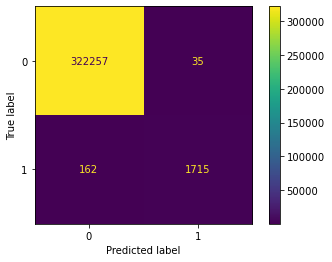

In [60]:
# plot confusion matrix
cat_predictions = cat.predict(X_test)

cat_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, cat_predictions, labels=cat.classes_), 
                                 display_labels=cat.classes_)
cat_disp.plot();

In [61]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,train accuracy,test accuracy,precision,recall,average precision,f1_score,roc_auc
0,Logistic Regression,0.997262,0.997085,0.887687,0.568460,0.507114,0.693082,0.979846
1,Gaussian Naive Bayes,0.978951,0.978650,0.179135,0.750133,0.135822,0.289206,0.948010
2,Random Forest Classifier,1.000000,0.998735,0.980984,0.797017,0.783035,0.879483,0.993896
3,XGBClassifier,0.999974,0.999386,0.984411,0.908364,0.894735,0.944860,0.999700
4,CatBoostClassifier,0.999985,0.999392,0.980000,0.913692,0.895918,0.945685,0.999708


### AutoML: PyCaret

In [ ]:
test nn

### Neural Network

In [77]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # equal to fully connected
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping


In [110]:
# Instantiate model
model = Sequential()

In [111]:
# One by one, add Dense layers to our model.
# The hidden layers will use the ReLU activation
# Output layer will have softmax
model.add(Dense(256, activation="relu", input_shape= (X_train_sc.shape[1],))) 
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [112]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               73984     
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 90,497
Trainable params: 90,497
Non-trainable params: 0
_________________________________________________________________


In [113]:
metrics = ['accuracy',
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp")
#     keras.metrics.Precision(name="precision"),
#     keras.metrics.Recall(name="recall"),
]

# We need to compile our model in Keras.
# Need to tell it three things:
# Optimizer (for us, usually Adam)
# Loss (which?)
# Metrics (Definitely need accuracy, but could do more)

#opt = SGD(learning_rate=0.01)
#opt = Adam(learning_rate=0.001) #10 to 20 epoch is max, if want then can increase the learning_rate

model.compile(
    optimizer= 'adam', #Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=metrics
)

# # Model Fit
# early_stop = EarlyStopping(monitor='val_loss', 
#                            min_delta=0, 
#                            patience=10, 
#                            mode='auto')

In [114]:
# Fit!
# Need to specify batch_size and epochs
# Can validate with validation_split
hist = model.fit(
    X_train_sc, y_train,
    batch_size=50,
    epochs=100,
    validation_data=(X_test_sc, y_test)
#     callbacks=[early_stop] # Add your callbacks here!
)

Epoch 1/100
19451/19451 [==============================] - 24s 1ms/step - loss: 0.0078 - accuracy: 0.9979 - fn: 1596.0000 - fp: 494.0000 - tn: 966383.0000 - tp: 4033.0000 - val_loss: 0.0062 - val_accuracy: 0.9983 - val_fn: 497.0000 - val_fp: 59.0000 - val_tn: 322233.0000 - val_tp: 1380.0000
Epoch 2/100
19451/19451 [==============================] - 22s 1ms/step - loss: 0.0045 - accuracy: 0.9987 - fn: 952.0000 - fp: 312.0000 - tn: 966565.0000 - tp: 4677.0000 - val_loss: 0.0051 - val_accuracy: 0.9986 - val_fn: 392.0000 - val_fp: 49.0000 - val_tn: 322243.0000 - val_tp: 1485.0000
Epoch 3/100
19451/19451 [==============================] - 22s 1ms/step - loss: 0.0036 - accuracy: 0.9991 - fn: 665.0000 - fp: 244.0000 - tn: 966633.0000 - tp: 4964.0000 - val_loss: 0.0065 - val_accuracy: 0.9988 - val_fn: 308.0000 - val_fp: 96.0000 - val_tn: 322196.0000 - val_tp: 1569.0000
Epoch 4/100
19451/19451 [==============================] - 23s 1ms/step - loss: 0.0028 - accuracy: 0.9992 - fn: 512.0000 - fp:

Epoch 29/100
19451/19451 [==============================] - 23s 1ms/step - loss: 3.7576e-04 - accuracy: 0.9999 - fn: 38.0000 - fp: 32.0000 - tn: 966845.0000 - tp: 5591.0000 - val_loss: 0.0358 - val_accuracy: 0.9988 - val_fn: 227.0000 - val_fp: 160.0000 - val_tn: 322132.0000 - val_tp: 1650.0000
Epoch 30/100
19451/19451 [==============================] - 23s 1ms/step - loss: 5.7481e-04 - accuracy: 0.9999 - fn: 35.0000 - fp: 29.0000 - tn: 966848.0000 - tp: 5594.0000 - val_loss: 0.0411 - val_accuracy: 0.9989 - val_fn: 249.0000 - val_fp: 105.0000 - val_tn: 322187.0000 - val_tp: 1628.0000
Epoch 31/100
19451/19451 [==============================] - 23s 1ms/step - loss: 0.0032 - accuracy: 0.9999 - fn: 39.0000 - fp: 36.0000 - tn: 966841.0000 - tp: 5590.0000 - val_loss: 0.0390 - val_accuracy: 0.9988 - val_fn: 225.0000 - val_fp: 152.0000 - val_tn: 322140.0000 - val_tp: 1652.0000
Epoch 32/100
19451/19451 [==============================] - 23s 1ms/step - loss: 8.4531e-04 - accuracy: 0.9999 - fn: 38

Epoch 57/100
19451/19451 [==============================] - 23s 1ms/step - loss: 3.9914e-04 - accuracy: 1.0000 - fn: 17.0000 - fp: 19.0000 - tn: 966858.0000 - tp: 5612.0000 - val_loss: 0.0788 - val_accuracy: 0.9989 - val_fn: 279.0000 - val_fp: 85.0000 - val_tn: 322207.0000 - val_tp: 1598.0000
Epoch 58/100
19451/19451 [==============================] - 23s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - fn: 21.0000 - fp: 22.0000 - tn: 966855.0000 - tp: 5608.0000 - val_loss: 0.0710 - val_accuracy: 0.9988 - val_fn: 274.0000 - val_fp: 104.0000 - val_tn: 322188.0000 - val_tp: 1603.0000
Epoch 59/100
19451/19451 [==============================] - 22s 1ms/step - loss: 9.8108e-04 - accuracy: 0.9999 - fn: 30.0000 - fp: 31.0000 - tn: 966846.0000 - tp: 5599.0000 - val_loss: 0.0706 - val_accuracy: 0.9989 - val_fn: 210.0000 - val_fp: 147.0000 - val_tn: 322145.0000 - val_tp: 1667.0000
Epoch 60/100
19451/19451 [==============================] - 23s 1ms/step - loss: 8.9967e-04 - accuracy: 0.9999 - fn: 29.

Epoch 85/100
19451/19451 [==============================] - 23s 1ms/step - loss: 0.0030 - accuracy: 1.0000 - fn: 21.0000 - fp: 20.0000 - tn: 966857.0000 - tp: 5608.0000 - val_loss: 0.0987 - val_accuracy: 0.9989 - val_fn: 258.0000 - val_fp: 107.0000 - val_tn: 322185.0000 - val_tp: 1619.0000
Epoch 86/100
19451/19451 [==============================] - 24s 1ms/step - loss: 9.7144e-04 - accuracy: 1.0000 - fn: 22.0000 - fp: 23.0000 - tn: 966854.0000 - tp: 5607.0000 - val_loss: 0.0824 - val_accuracy: 0.9988 - val_fn: 225.0000 - val_fp: 179.0000 - val_tn: 322113.0000 - val_tp: 1652.0000
Epoch 87/100
19451/19451 [==============================] - 24s 1ms/step - loss: 5.5722e-04 - accuracy: 1.0000 - fn: 23.0000 - fp: 21.0000 - tn: 966856.0000 - tp: 5606.0000 - val_loss: 0.1016 - val_accuracy: 0.9989 - val_fn: 232.0000 - val_fp: 117.0000 - val_tn: 322175.0000 - val_tp: 1645.0000
Epoch 88/100
19451/19451 [==============================] - 23s 1ms/step - loss: 6.2002e-04 - accuracy: 0.9999 - fn: 24

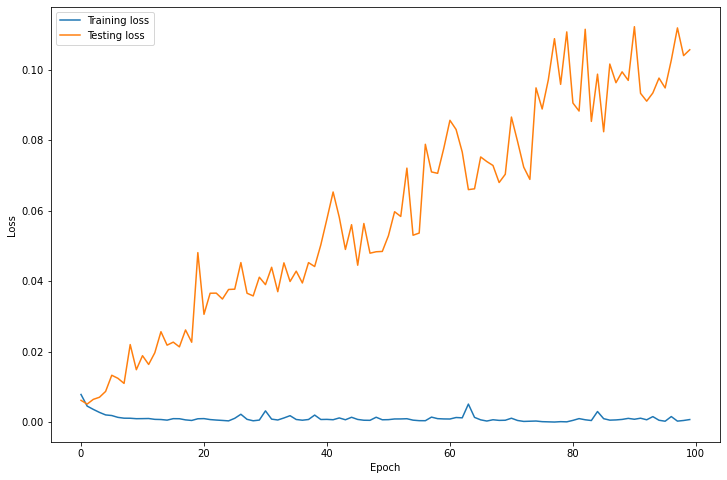

In [116]:
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

## Hyperparameters Tuning

In [30]:
# XGB Classifier
xgb_params = {'eval_metric':['auc'],
              'learning_rate':[0.1],
              'subsample':[0.5],
              'colsample_bytree':[0.5],
              'max_depth':[3],
              'scale_pos_weight':[19],
              'n_estimators':[500],
              'reg_alpha':[0,1,1.5], 
              'reg_lambda':[1,3,5], 
              'gamma':[0.01,0.1, 3]
              }

In [ ]:
%%time

# Instantiate our model.
xgb_gs = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder = False, seed=42), 
                     xgb_params , cv=5, verbose=1, n_jobs= -1)

# Fit our model.
xgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
# check best params and CV score
print(xgb_gs.best_params_)
print(xgb_gs.best_score_)

In [ ]:
# print the summarize report and store the values
run_score(xgb_gs, 'XGB Classifier GridSearchCV', scale=False)

In [ ]:
# plot confusion matrix
xgb_gs_predictions = xgb_gs.predict(X_test)

xgb_gs_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, xgb_gs_predictions, labels=xgb_gs.classes_), 
                              display_labels=xgb_gs.classes_)
xgb_gs_disp.plot();

### Isolation Forest

In [275]:
from sklearn.ensemble import IsolationForest #unsupervised model

In [361]:
%%time

isof = IsolationForest(n_estimators=300,max_samples='auto', random_state=42, max_features=10, contamination=0.2)
isof.fit(X_test)

Wall time: 27.7 s


IsolationForest(contamination=0.2, max_features=10, n_estimators=300,
                random_state=42)

In [362]:
isof.decision_function(X_test)

array([-0.00429815, -0.00470222,  0.00952013, ...,  0.00248539,
       -0.00167395,  0.01878733])

In [363]:
isof_df = X_test.copy()

In [364]:
isof_df['scores'] = isof.decision_function(X_test)

In [365]:
isof_df['anomaly_score'] = isof.predict(X_test)

In [366]:
isof_df['anomaly_score'].value_counts()

 1    259138
-1     64785
Name: anomaly_score, dtype: int64

In [367]:
isof_df['anomaly_score'] = isof_df['anomaly_score'].map({1:0, -1:1})

In [368]:
isof_df[isof_df['anomaly_score'] == 0].head()

,amt,gender,lat,long,city_pop,merch_lat,merch_long,trans_year,trans_month,trans_week,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,scores,anomaly_score
972892,51.93,0,30.5920,-97.2893,1766,30.394796,-96.993281,2020,1,5,...,1,0,0,0,0,0,0,0,0.009520,0
602015,45.71,0,30.6576,-91.6264,1178,30.579323,-91.909866,2019,9,37,...,0,0,0,0,0,0,0,0,0.004941,0
991252,42.64,0,45.8327,-91.0144,1478,44.984610,-90.928320,2020,2,6,...,0,0,0,0,0,1,0,0,0.004859,0
416961,203.46,0,33.7467,-117.1721,54287,34.371357,-117.375605,2019,7,27,...,0,0,0,0,0,0,0,0,0.005501,0
124787,16.31,0,41.0767,-74.5982,2456,41.953531,-73.738652,2019,3,10,...,0,0,0,0,0,0,0,0,0.003507,0


In [369]:
isof_df['is_fraud'] = y_test

In [370]:
isof_df[(isof_df['anomaly_score'] == 1) & (isof_df['is_fraud'] == 1)].head()

,amt,gender,lat,long,city_pop,merch_lat,merch_long,trans_year,trans_month,trans_week,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,scores,anomaly_score,is_fraud
1097799,327.93,0,37.7256,-81.1087,3994,37.502289,-80.131803,2020,4,14,...,0,0,0,0,0,1,0,-0.012683,1,1
1182318,14.62,1,31.8092,-106.4247,749635,31.564330,-107.181624,2020,5,19,...,0,0,0,0,0,0,0,-0.010178,1,1
36187,746.76,0,27.4703,-81.4872,50835,28.213586,-80.990412,2019,1,4,...,0,0,0,0,0,0,0,-0.022666,1,1
55483,20.13,0,46.1838,-101.2589,77,45.244930,-101.171103,2019,2,5,...,0,0,0,0,0,0,0,-0.008105,1,1
98005,874.98,0,40.9086,-73.8221,67100,41.050200,-74.083291,2019,2,9,...,0,0,0,0,0,0,0,-0.023307,1,1


In [371]:
isof_df[(isof_df['anomaly_score'] == 0) & (isof_df['is_fraud'] == 1)]

,amt,gender,lat,long,city_pop,merch_lat,merch_long,trans_year,trans_month,trans_week,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,scores,anomaly_score,is_fraud
423267,569.01,0,34.4596,-93.6743,1383,33.680223,-94.545012,2019,7,28,...,0,0,0,0,0,0,0,0.003025,0,1
1185926,17.99,0,42.1782,-83.2461,15623,42.440892,-82.951309,2020,5,19,...,0,0,0,0,0,0,0,0.003773,0,1
276323,989.16,0,34.3470,-87.7154,5778,34.928611,-88.653070,2019,5,20,...,0,0,0,0,0,0,0,0.009556,0,1
376293,17.81,1,26.1184,-81.7361,276002,26.034018,-81.165716,2019,6,25,...,0,0,0,0,0,0,0,0.004060,0,1
841989,11.82,1,36.5422,-88.3319,1480,35.685682,-88.272868,2019,12,50,...,0,0,0,0,0,0,0,0.002494,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685858,18.29,0,42.8948,-74.8209,824,43.705239,-74.423520,2019,10,42,...,0,0,0,0,0,0,0,0.021122,0,1
423293,922.33,0,40.4815,-92.9951,3805,40.641401,-93.820428,2019,7,28,...,0,0,0,0,0,0,0,0.005289,0,1
154235,18.35,0,36.5220,-87.3490,151785,36.754307,-88.172838,2019,3,12,...,0,0,0,0,0,0,0,0.013764,0,1
690760,18.60,0,43.7893,-75.4156,8830,43.242477,-75.526455,2019,10,43,...,0,0,0,0,0,0,0,0.010449,0,1


In [372]:
print(confusion_matrix(y_test, isof_df['anomaly_score']))

[[258584  63481]
 [   554   1304]]


In [273]:
# %%time
# knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)

In [274]:
# # plot confusion matrix
# plot_confusion_matrix(knn, X_test, y_test, display_labels=['not_fraud', 'is_fraud'], 
#                       cmap='Blues', values_format='d');

NameError: name 'knn' is not defined

In [ ]:
# # print the summarize report and store the values
# run_score(knn, 'KNeighborsClassifier')

In [ ]:
# # Updated evaluation list
# pd.DataFrame(evaluation_list)

In [ ]:
# DNN with SMOTE
# https://towardsdatascience.com/credit-card-fraud-detection-9bc8db79b956